# Voting

In [1]:
#1

# Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Importing the dataset
dataset = pd.read_csv('CVD dataset-plin-7-9.csv') #διαβάζω το dataset που δεν περιλαμβανει τα features 7 και 9
data=dataset.iloc[:, :].values
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 14].values
# print(X[0])
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,4,5,6,7])], remainder='passthrough')
# X = np.array(ct.fit_transform(X))
# print(X[0][20])
rows = len(data)    # 3 rows in your example
cols = len(X[0])
cols = len(data[0])
print(rows)
print(cols)

560
15


In [2]:
#14 prin
OHE=20
dataNoCvd = data[~(data[:,14] > 0.0)] #χωρίζω τα data σε 2 πίνακες, ο ένας με τα cvd ο άλλος με τα όχι cvd
dataCvd = data[~(data[:,14] < 1.0)]
rowsNoCvd = len(dataNoCvd)    
rowsCvd = len(dataCvd)
print(rowsNoCvd)
print(rowsCvd)

519
41


## Training Testing Validation sets

Τα instances με cvd είναι 41 και χωρίς cvd είναι 519, συνολικά είναι δηλαδή 560. Άρα στο 10-fold cross validation το test set θα περιλαμβάνει 56 instances και τα υπόλοιπα 504 θα διατεθούν για το training. Όμως επειδή το 10% του training θα δωθεί στο validation set αυτό σημαίνει ότι τελικά 50 instances θα ανήκουν στο validation set και με τα υπόλοιπα 454 θα γίνεται το training.

### Testing
41//10=4 και υπόλοιπο 1
519//10=51 και υπόλοιπο 9 
Γιαυτό τα πρώτα 9 test set θα πάρουν από ένα extra NoCvd instance άρα θα έχουν NoCvd:52 Cvd:4
το 10ο test set θα πάρει το  extra Cvd instance άρα θα έχει NoCvd:51 Cvd:5

### Validation
Το validation set θα έχει όπως είπαμε 50 instances και σταθερά NoCvd:46 Cvd:4
Για να φτιάξουμε το validation set για κάθε fold θα παίρνουμε κάθε φορά τα επόμενα 46 instances από αυτά που πήραμε για το test set από τον πίνακα που θα περιέχει όλα τα instances χωρίς cvd και τα επόμενα 4 instances από αυτά που πήραμε για το test set από τον πίνακα που θα περιέχει όλα τα instances με cvd. Μόνο στην περίπτωση του 10ου fold θα πάρουμε τα 46 και τα 4 instances που προηγούνται των instances που πήραμε για το test set και αυτό γιατί δεν θα υπάρχουν επόμενα instances για να τα πάρουμε. Το ακόλουθο σχήμα δείχνει πώς γίνεται ο χωρισμός στην περίπτωση των 1,2,9 και 10 fold.

### Training 
Όσα instances περισσεύουν από το test και validation set. Άρα ο συνολικός του αριθμός θα είναι 454 και στα πρώτα 9 folds θα έχει NoCvd:421 Cvd:33 και στο 10ο fold θα έχει NoCvd:422 και Cvd:32

<!-- <img src="fold-1-2.png"> -->
<img src="fold-1-2-site.svg">
<img src="fold-9-10-site.svg">


In [3]:
def find_NoCvd_limitsArray(i,DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue):
    if i>0 :
        DownNoCvd = UpNoCvd
        UpNoCvd= fold_NoCvd_total+UpNoCvd
    if i < fold_NoCvd_residue :
        UpNoCvd+= 1
    return   DownNoCvd, UpNoCvd   
 
def find_Cvd_limitsArray(i,DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv):
    if i>0 :
        DownCvd = UpCvd
        UpCvd= fold_Cvd_total+UpCvd
    if i >= cv - fold_Cvd_residue :
         UpCvd+= 1     
    return   DownCvd, UpCvd  

def find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd):
    temp1=dataNoCvd[DownNoCvd:UpNoCvd,:]
    temp2=dataCvd[DownCvd:UpCvd,:]
    temp3=np.concatenate((temp1, temp2))
    return temp3

def find_trainSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
    temp3 = np.concatenate((temp1, temp2))
    return temp1, temp2, temp3

def find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
    print("len 1-2:",len(temp1),len(temp2))
    temp3 = np.delete(temp1, slice(0, 46), axis=0)
    temp4 = np.delete(temp2, slice(0, 4), axis=0)
    print("len 3-4:",len(temp3),len(temp4))
    temp5 = np.concatenate((temp3, temp4))
    print(len(temp5))
    return temp3, temp4, temp5

In [4]:
def create_train_test_sets(cv,dataNoCvd,dataCvd,val_ratio):
    # cv= αριθμός των folds, κάνω 10-fold cross validation γιαυτό το έχω θέσει 10
    # val_ratio= το ποσοστό του training set που θα γίνει validation set, το έβαλα 10%
    test_total = []
    train_total = []
    train_total_Cvd = []
    train_total_NoCvd = []
    validation_total = []
    
    #στόχος είναι να χωρίσουμε τα δεδομένα σε 10 folds με ποσοστό instances με cvd περιπου 7%, το 1 fold θα                                
    #χρησιμοποιείται για test και τα άλλα 9 θα ενωνονται και θα χρησιμοποιούνται για train-validation
    
    rowsNoCvd = len(dataNoCvd)    # βρίσκω τον αριθμό των instances χωρίς cvd
    rowsCvd = len(dataCvd)        # βρίσκω τον αριθμό των instances με cvd

    #fold_Cvd_total = αριθμός των instances με cvd που θα μπουν  σίγουρα στο 1 fold = 4
    fold_Cvd_total = rowsCvd//cv 
    #fold_Cvd_residue = το υπόλοιπο των instances που πρέπει να το μοιράσουμε στα 10 folds, δηλαδη κάποια 
    #θα έχουν ένα instance με cvd παραπάνω = 1
    fold_Cvd_residue= rowsCvd%cv
    print("fold_Cvd_total  :",fold_Cvd_total," fold_Cvd_residue  :",fold_Cvd_residue)

    #fold_NoCvd_total = αριθμός των instances χωρίς cvd που θα μπουν  σίγουρα στο 1 fold = 51
    fold_NoCvd_total = rowsNoCvd//cv
    #fold_NoCvd_residue = το υπόλοιπο των instances που πρέπει να το μοιράσουμε στα 10 folds, δηλαδη κάποια 
    #θα έχουν ένα instance χωρίς cvd παραπάνω = 9
    fold_NoCvd_residue= rowsNoCvd%cv
    print("fold_NoCvd_total:",fold_NoCvd_total,"fold_NoCvd_residue:",fold_NoCvd_residue)
    
    #Cvd_val= αριθμός instances με cvd που θα μπει στο validation set,το train set αποτελείται από 504 instances  
    #από αυτά το 7% είναι cvd, εμείς από το 7% θα πάρουμε το 10% για το validatio set
    Cvd_val = round(504*val_ratio*(rowsCvd/len(data)))
    #504*val_ratio= ο συνολικός αριθμός των instances  με του validation set, άρα αν από αυτόν αφαιρέσουμε 
    #το Cvd_val θα πάρουμε των αριθμό των instances χωρίς cvd που θα μπουν στο validation set
    noCvd_val = round(504*val_ratio)-Cvd_val
    
    #dataNoCvd= [0 1 2 .... 517 518] αυτοί είναι οι δείκτες του πίνακα με όλα τα NoCvd instances, τα  DownNoCvd και
    # UpNoCvd θα είναι οι δείκτες στους οποίους θα γίνεται το χώρισμα του πίνακα dataNoCvd κάθε φορά προκειμένου
    # να πάρουμε ένα fold, DownNoCvd=κάτω όριο, UpNoCvd= πάνω όριο, ξεκινάμε με DownNoCvd=0(από την αρχή του πίνακα)
    # UpNoCvd = fold_NoCvd_total(αριθμός NoCvd instances που θα μπουν σίγουρα στο fold)
    #
    #dataCvd= [0 1 2.. 39 40] δείκτες του πίνακα dataCvd, με την ίδια λογική με πριν DownCvd=0=κάτω όριο-δείκτης
    # UpCvd= άνω όριο-δείκτης=fold_Cvd_total(αριθμός Cvd instances που θα μπουν σίγουρα στο fold)
    DownNoCvd=0
    DownCvd=0
    UpNoCvd = fold_NoCvd_total
    UpCvd = fold_Cvd_total
    #τα όρια αυτά θα αλλάξουν 10 φορές, όσα είναι και τα fold 
    
    for i in range(cv):
        X_test = []
        y_test = []
        X_train = []
        y_train = []
        X_val = []
        y_val = []
        
        #find_NoCvd_limitsArray = βρίσκει τα όρια του dataNoCvd πίνακα για το i fold
        DownNoCvd, UpNoCvd = find_NoCvd_limitsArray(i, DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue)
        #find_Cvd_limitsArray = βρίσκει τα όρια του dataCvd πίνακα για το i fold
        DownCvd, UpCvd = find_Cvd_limitsArray(i, DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv)

        #find_testValSubset = επιστρέφει τον πίκακα test για το i-fold
        testSubset_total = find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd)        
        
        if i!=9:
        #όταν δεν είμαστε στο 10ο fold(ξεκινάμε από 0) παίρνουμε τα επόμενα 56 και 4 instaces για το validation set
            validationSubset_total = find_testValSubset(UpNoCvd,UpNoCvd+noCvd_val,UpCvd,UpCvd+Cvd_val)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset(DownNoCvd,UpNoCvd+noCvd_val,DownCvd,UpCvd+Cvd_val)
        else:
        #όταν είμαστε στο 10ο fold παίρνουμε τα προηγούμενα 56 και 4 instaces για το validation set
#         DownNoCvd-noCvd_val,DownNoCvd,DownCvd-Cvd_val,DownCvd
            validationSubset_total = find_testValSubset(0,noCvd_val,0,Cvd_val)
            print(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
    
    #creating X_train, y_train, X_test, y_test
        #για να δημιουργήσω το X_test αφαιρώ απλά την τελευταία στήλη
        X_test.append(np.delete(testSubset_total, 14, axis=1))
        y_test_temp = np.delete(testSubset_total, slice(0, 14), axis=1)
        #για το y_test κρατάω μόνο την τελευταία στήλη 
        y_test.append(np.reshape(y_test_temp, len(y_test_temp)))
        #οι ακόλουθες γραμμές κώδικα είναι για να φέρω τα X_test και y_test στην μορφή πίνακα που θέλω
        X_test_temp = np.array(X_test)
        X_test = X_test_temp[0]
        y_test_temp = np.array(y_test)
        y_test = y_test_temp[0]
        
        #για να δημιουργήσω το X_val αφαιρώ απλά την τελευταία στήλη
        X_val.append(np.delete(validationSubset_total, 14, axis=1))
        y_val_temp = np.delete(validationSubset_total, slice(0, 14), axis=1)
        #για το y_val κρατάω μόνο την τελευταία στήλη 
        y_val.append(np.reshape(y_val_temp, len(y_val_temp)))
        X_val_temp = np.array(X_val)
        X_val = X_val_temp[0]
        y_val_temp = np.array(y_val)
        y_val = y_val_temp[0]
        
        #για να δημιουργήσω το X_train αφαιρώ απλά την τελευταία στήλη
        X_train.append(np.delete(trainSubset_total, 14, axis=1))
        y_train_temp = np.delete(trainSubset_total, slice(0, 14), axis=1)
        #για το y_train κρατάω μόνο την τελευταία στήλη 
        y_train.append(np.reshape(y_train_temp, len(y_train_temp)))
        X_train_temp = np.array(X_train)
        X_train = X_train_temp[0]
        y_train_temp = np.array(y_train)
        y_train = y_train_temp[0]
        
    #αποθηκεύω τα X_test,y_test στον πίνακα test_total οπότε στην i-οστή θέση θα είναι τα X_test,y_test για το i fold 
    #το ίδιο κάνω και με τους πίνακες validation_total και train_total
        test_total.append([X_test,y_test])
        validation_total.append([X_val,y_val])
        train_total.append([X_train,y_train]) 
    #train_total_NoCvd:αποθηκεύω τα instances χωρίς Cvd πουθα χρησιμοποιηθούν για training όταν θα είμαστε στο i-fold
        train_total_NoCvd.append(trainSubset_NoCvd)
    #train_total_Cvd:αποθηκεύω τα instances με Cvd πουθα χρησιμοποιηθούν για training όταν θα είμαστε στο i-fold
        train_total_Cvd.append(trainSubset_Cvd)
    return train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd

In [5]:
train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd = create_train_test_sets(10,dataNoCvd,dataCvd,0.1)
# print((test_total[9][0]))

fold_Cvd_total  : 4  fold_Cvd_residue  : 1
fold_NoCvd_total: 51 fold_NoCvd_residue: 9
468 519 36 41
len 1-2: 468 36
len 3-4: 422 32
454


In [6]:
print(len(train_total[9][0]))

454


In [7]:
# Chech ratio in each train and test set and validation set
def find_ratio(index_list):
    one = 0
    lenght=len(index_list[0])
    for i in range(lenght):
#         print(index_list[1])
        if index_list[1][i] == 1.0 :
            one+= 1
    ratio = one/lenght
    return ratio

for i in range(10):
    print(len(train_total[i][0]))
    ratio = find_ratio(train_total[i])
    print("ratio in train set:", ratio)
    ratio = find_ratio(test_total[i])
    print("ratio in test set:", ratio)
    ratio = find_ratio(validation_total[i])
    print("ratio in validation set:", ratio)

454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in vali

In [31]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
import shap


def my_fit(ratio,dataNoCvd,dataCvd, validation_total, params):   
    Subarray=[]
    models = []
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)

#Για ratio 1:2 πρέπει να φτιαχτούν 6 μοντέλα
    numOfSubsamples = rowsNoCvd//(rowsCvd*ratio)
    numOfSubsamples= int(numOfSubsamples)
    SubNoCvd = rowsNoCvd//numOfSubsamples
    residue = rowsNoCvd- SubNoCvd*numOfSubsamples


    Up = 0
    valid_preds = []

    for i in range(numOfSubsamples):
        classifier = XGBClassifier(base_score=params[11], booster='gbtree', colsample_bylevel=params[5],
                  colsample_bynode=params[12], colsample_bytree=params[8], gamma=params[4],
                  learning_rate=params[0], max_delta_step=params[13], max_depth=params[1],
                  min_child_weight=params[3], missing=None, n_estimators=params[2], n_jobs=1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=params[9], reg_lambda=params[6], scale_pos_weight=params[7], seed=None,
                  silent=None, subsample=params[10], verbosity=1)

#για να φτιάξουμε το training set αφού τα μοντέλα είναι 6 πρέπει να χωρίσουμε τα instances NoCvd στα 6
#στα πρώτα 9-fold τα NoCvd instances είναι 421, άρα 421//6=70 με υπόλοιπο 1
#στο 10ο fold τα NoCvd instances είναι 422, άρα 422//6=70 με υπόλοιπο 2
#τα υπόλοιπα μπαίνουν στα πρώτα μοντέλα δηλαδή στα πρώτα 9-fold το πρώτο μοντέλο θα πάρει 71 NoCvd instances
#και στο 10ο fold το πρώτο αλλά και το δεύτερο θα πάρουν 71 instances. Τα υπόλοιπα θα πάρουν από 70
        Down = Up
        Up= Up + SubNoCvd
        if i < residue :
            Up+= 1
        
        Sub1=dataNoCvd[Down:Up,:]
        #φτίαχνουμε πίνακα με τα NoCvd instances που βρήκαμε ότι αναλογούν σε κάθε μοντέλο και με όλα τα Cvd instances
        Sub2=np.concatenate((Sub1, dataCvd))
        Subarray.append(Sub2)
        

    #Dividing to X and y of the previous traing set    
        X=np.delete(Subarray[i], 14, axis=1)
        y=np.delete(Subarray[i], slice(0, 14), axis=1)
        y=np.reshape(y, len(y))
#         print("uuuuuuuuuuuuuuuuu")
#         print(X[0])
#         ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,4,5,6,7])], remainder='passthrough')
#         X = np.array(ct.fit_transform(X))
#         print(X[0])
        
        X_val = validation_total[i][0]
        y_val = validation_total[i][1]
        
        eval_set  = [(X,y), (X_val,y_val)]
        #κάνουμε fit με χρήση early stopping
        classifier.fit( X, y, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=40,verbose = False )
  
        print("model",i," :",classifier.best_iteration) 
        
        #υπολογίζουμε το auc που έχει το μοντέλο για το validation set γιατί θα μας χρειαστεί στο weighted voting
        auc_valid = roc_auc_score(y_val, classifier.predict(X_val))
        print("auc_valid",auc_valid,classifier.best_score, classifier.best_ntree_limit)
        
        #αποθηκεύουμε τα auc σε πίνακα για να τα επιστέψουμε όλα μαζί
        valid_preds.append(auc_valid)

        explainer = shap.TreeExplainer(classifier)
        # calculate shap values. This is what we will plot.
        # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
        print(len(X))
        shap_values = explainer.shap_values(X)
        # Make plot. Index of [1] is explained in text below.
        
        feature_names = ['Gender','Age','DD','BMI','Smoking','Hypert','ypolip','asa','PulsBP','aca0','gla0','chl0','tg0','hdl0']
       
        if(i==1):
        # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
            print(len(shap_values))
            print(len(shap_values[0]))
            sss=0
            for k in range(len(shap_values[0])):
                sss += shap_values[1][k]
            print("sssssssss   ",sss)
            print("ppppppppp   ",classifier.predict(X))
            print("probaprob   ",classifier.predict_proba(X)[:,1]) 
            print("ppppppppp   ",classifier.predict(X,output_margin=True))
            print("explainer.expected_value",explainer.expected_value)
            print("  sum       ",sss+explainer.expected_value)
            shap.force_plot(explainer.expected_value, shap_values[1,:], X[1],feature_names,matplotlib=True)
            shap.force_plot(explainer.expected_value, shap_values[1,:], X[1],feature_names,matplotlib=True,link='logit')
            shap.force_plot(explainer.expected_value, shap_values[100,:], X[100],feature_names,matplotlib=True,link='logit')

#         shap.force_plot(explainer.expected_value, shap_values, X)
    
#         shap.summary_plot(shap_values, X,feature_names)
#         shap.summary_plot(shap_values, X, plot_type="bar")
#         shap.dependence_plot(1, shap_values, X,feature_names)
#         #rank(1) επιστρέφει το μεγαλύτερο
#         shap.dependence_plot("rank(1)", shap_values, X, interaction_index='Feature 9')
        #ο κώδικας που ακολουθεί και είναι σε σχόλια είναι για να τυπώνει το πρώτο δένδρο κάθε μοντέλου xgboost
#         plot_tree(classifier)     
#         plt.rcParams["figure.figsize"] = (40,7)
#         plot_tree(classifier, num_trees=0, rankdir='LR')
#         plt.show()

        models.append(classifier)
    return models,valid_preds

In [10]:
def voting(models,X,auc_valid):
    y_pred = []
    y_pred_models = []
    
    models_size = len(models)
    X_size = len(X)
            
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X))
       
        
    for j in range(X_size):
        case = 0
        for i in range(models_size):
            if y_pred_models[i][j] == 1.0:
                case+=1
        if case >  models_size/2 :
            y_pred.append(1.) 
        else:
            y_pred.append(0.) 
            
    return y_pred  

In [ ]:
    total_shap_values = []
    for i in range(models_size):
        explainer = shap.TreeExplainer(models[i])
        # calculate shap values. This is what we will plot.
        # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
        print(len(X))
        shap_values = explainer.shap_values(X)
#         shap_values_auc = [[l*(auc_valid[i]/sum_auc) for l in k] for k in shap_values]
      
        
        if(i==0):
             total_shap_values = shap_values.copy()
        else:
            for a in range(len(total_shap_values)):
                for b in range(len(total_shap_values[0])):
                     total_shap_values[a][b] += shap_values[a][b]
        
        
        feature_names = ['Gender','Age','DD','BMI','Smoking','Hypert','ypolip','asa','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
        shap_values = explainer.shap_values(X)
 
        
        t_shap_values = numpy.array(total_shap_values) 

      
    shap.force_plot(explainer.expected_value, t_shap_values[50,:], X[50],feature_names,matplotlib=True,link='logit')
#         shap.force_plot(explainer.expected_value, shap_values[100,:], X[100],feature_names,matplotlib=True,link='logit')
            
 

In [ ]:
total_shap_values = []
    for i in range(models_size):
        explainer = shap.TreeExplainer(models[i])
        # calculate shap values. This is what we will plot.
        # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
        print(len(X))
        shap_values = explainer.shap_values(X)
        shap_values_auc = [[l*(auc_valid[i]/sum_auc) for l in k] for k in shap_values]
        print((shap_values))
        print((auc_valid[i]/sum_auc))
        print((shap_values_auc))
        
        if(i==0):
             total_shap_values = shap_values_auc.copy()
        else:
            for a in range(len(total_shap_values)):
                for b in range(len(total_shap_values[0])):
                     total_shap_values[a][b] += shap_values_auc[a][b]
        
        print(len(total_shap_values))
        print(len(total_shap_values[0]))
        feature_names = ['Gender','Age','DD','BMI','Smoking','Hypert','ypolip','asa','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
        shap_values = explainer.shap_values(X)
 
        print(type(shap_values))
        print(type(shap_values_auc))
        t_shap_values = numpy.array(total_shap_values)

In [12]:
#weighted voting
def weighted_voting(models,X,auc_valid):
    y_pred = []
    y_pred_models = []
    sum_auc = 0
    print("auc_valid:",mean(auc_valid))
    models_size = len(models)
    X_size = len(X)
            
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X))
#         y_pred_models.append(models[i].predict(X,output_margin=True))
#         y_pred_models.append(models[i].predict_proba(X)[:,1]) 
#         print('==================',models[i].predict(X,output_margin=True),models[i].predict(X),'================')
        sum_auc += auc_valid[i]
    
    total_shap_values = []
    total_expected_value = 0
    for i in range(models_size):
        explainer = shap.TreeExplainer(models[i])
        # calculate shap values. This is what we will plot.
        # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
 
        shap_values = explainer.shap_values(X)
        shap_values_auc = [[l*(1/6) for l in k] for k in shap_values]
#         print((shap_values))
#         print((auc_valid[i]/sum_auc))
#         print((shap_values_auc))
        
        if(i==0):
             total_shap_values = shap_values_auc.copy()
        else:
            for a in range(len(total_shap_values)):
                for b in range(len(total_shap_values[0])):
                     total_shap_values[a][b] += shap_values_auc[a][b]
        total_expected_value += explainer.expected_value*(1/6) 
        print("explainer.expected_value",explainer.expected_value)
  
    feature_names = ['Gender','Age','DD','BMI','Smoking','Hypert','ypolip','asa','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
       
 
    t_shap_values = numpy.array(total_shap_values)
    

      
    shap.force_plot(total_expected_value, t_shap_values[1,:], X[1],feature_names,matplotlib=True,link='logit')
#         shap.force_plot(explainer.expected_value, shap_values[100,:], X[100],feature_names,matplotlib=True,link='logit')
            
            
            
            
            
    for j in range(X_size):
        case = 0
        for i in range(models_size):
#             case += y_pred_models[i][j]*(auc_valid[i]/sum_auc)*100 #auc_valid[i]/sum_auc --> η δύναμη της ψήφου
            case += y_pred_models[i][j]                                                        #του μοντέλου

#έβαλα case>56 και όχι case>,50(επειδή έχω κάνει *100 πίο πάνω μου ήταν πιο εύκολο στην κατανόηση, αλλίως
#θα έπρεπε να είναι case>0.5), διότι το case>56 έδινε καλύτερο τελικό auc              
        if case >  3 :
            y_pred.append(1.)
            if(j==1):
                print("11111111111111")
        else:
            y_pred.append(0.) 
           
        
            
    return y_pred  

In [13]:
o=[[1,2,3],[44,4,4],[9,5,2]]
# for i in range(len(o)):
#     o[i] = o[i]*4
# print(o)
print([[j*5 for j in i] for i in o])
p=[[1,1,1],[1,1,1],[1,1,1]]
o+p

[[5, 10, 15], [220, 20, 20], [45, 25, 10]]


[[1, 2, 3], [44, 4, 4], [9, 5, 2], [1, 1, 1], [1, 1, 1], [1, 1, 1]]

In [14]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
#https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from sklearn import metrics

def my_cross_val( cv, train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd,params):
    accuracy = []
    specificity = []
    sensitivity = []
    auc = []
    

    for i in range(cv):
        print("----------------",i,"- fold -----------------------")
        print("                  Estimators")
        #από τον πίνακα test_total παίρνω τα X_test,y_test για το i-fold
        X_test = test_total[i][0]
        y_test = test_total[i][1]
        
        #εφαρμόζω fit που μου επιστέφει το ensemble μοντέλο και τις επιδόσεις-auc του κάθε μοντέλου xgboost
        #που υπολογίζονται από τα validation set,από τα οποία αποτελείται το ensemble μοντέλο
        models,auc_valid = my_fit( 2, train_total_NoCvd[i], train_total_Cvd[i], validation_total,params)

        #εφαρμόζουμε weighted voting για να βρούμε την πρόβλεψη του ensemble model
        #στο weighted voting θα έχουν πιο ισχυρή ψήφο τα μοντέλα με μεγαλύτερο auc στο validation set 
        y_pred = weighted_voting(models,X_test,auc_valid)
#         y_pred = voting(models,X_test,auc_valid)

        cm = confusion_matrix(y_test, y_pred)

        total1=sum(sum(cm))
        #####from confusion matrix calculate accuracy
        accuracy1=(cm[0,0]+cm[1,1])/total1
        
#         accuracy1=accuracy_score(y_test, y_pred) #άλλος τρόπος για υπολογισμό accuracy

        specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])

        sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
        
        auc1 = roc_auc_score(y_test, y_pred)
        print(auc1)
        accuracy.append(accuracy1)
        specificity.append(specificity1)
        sensitivity.append(sensitivity1) 
        auc.append(auc1)
    #επιστρέφουμε πίνακες και με τα 10 accuracy, specificity, sensitivity, auc που προκύπτουν από το 10 fold cross
    #validation
    print(auc)
    return accuracy, specificity, sensitivity, auc

In [15]:
# https://www.geeksforgeeks.org/python-all-possible-permutations-of-n-lists/

def compute_comb(params):
    
    # initializing lists 
    list1 = params.get("learning_rate")
    list2 = params.get("max_depth")
    list3 = params.get("n_estimators") 
    list4 = params.get("min_child_weight")
    list5 = params.get("gamma")    
    list6 = params.get("colsample_bylevel")
    list7 = params.get("reg_lambda") 
    list8 = params.get("scale_pos_weight")
    list9 = params.get("colsample_bytree")
    list10 = params.get("reg_alpha")
    list11 = params.get("subsample")
    list12 = params.get("base_score")
    list13 = params.get("colsample_bynode")
    list14 = params.get("max_delta_step")
    
    # to compute all possible permutations 
    res = [[i, j, k, l, m, n, o, p,q,r,s,t, u, v] for i in list1  
                                                  for j in list2 
                                                  for k in list3 
                                                  for l in list4 
                                                  for m in list5 
                                                  for n in list6 
                                                  for o in list7
                                                  for p in list8
                                                  for q in list9
                                                  for r in list10
                                                  for s in list11
                                                  for t in list12
                                                  for u in list13
                                                  for v in list14] 

    return res

In [16]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [17]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from statistics import mean

def gridsearch(params):
    max_sens = 0
    max_spes = 0
    max_acc = 0
    best_params = []
    max_params = []
    max_auc = 0
    #compute_comb = υπολογίζει όλους τους συνδυασμους των παραμέτρων που της δώσαμε να ελέγξει
    combs = compute_comb(params)
    print(len(combs))
    
    #για κάθε έναν συνδυασμό θα κάνουμε cross validation
    for j in range(len(combs)):
        print(j)
        accuracy, specificity, sensitivity, auc = my_cross_val( 10, train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd,combs[j])
        if mean(auc)>0.65:
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
            print(combs[j])
            print (style.BOLD + 'accuracy    ' + style.END, mean(accuracy))
            print (style.BOLD + 'specificity ' + style.END, mean(specificity))
            print (style.BOLD + 'sensitivity ' + style.END, mean(sensitivity))
            print (style.BOLD + 'auc         ' + style.END, mean(auc))
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
        
        #ο πίνακας best_params θα περιέχει όλα τα αποτελέσματα όλων των συνδυασμών για να μπορούμε στο τέλος
        #της gridsearch να βρούμε τα καλύτερα
        #βλέπουμε ότι γίνεται αποθήκευση των mean γιατί η my_cross_val πιστρέφουμε πίνακες και με τα 
        #10 accuracy, specificity, sensitivity, auc που προκύπτουν από το 10 fold cross validation
        best_params.append([combs[j],mean(accuracy),mean(specificity),mean(sensitivity),mean(auc)])
        #αποθηκεύουμε τον συνδυασμό των παραμέτρων που μας δίνει το καλύτερο auc
        if mean(auc)> max_auc:
            max_sens = mean(sensitivity)
            max_spes = mean(specificity)
            max_acc = mean(accuracy)
            max_auc = mean(auc)
            max_params = combs[j]
    return max_sens, max_params, max_spes, max_acc, max_auc, best_params

# Ratio = 2

In [18]:
params = {
                    "learning_rate"    :[0.3],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[200],
                    "min_child_weight" :[1],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.75], #0.5-1 0.75
                     "reg_lambda"      :[2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3],
                    "colsample_bytree" :[0.5],
                    "reg_alpha"        :[0.2],
                    "subsample"        :[0.8],
                    "base_score"       :[0.5],
                    "colsample_bynode" :[1],
                    "max_delta_step"   :[0]
            
        }
# new features [3, 14, 13, 11, 15, 1, 2, 12, 10, 5, 6, 8, 0, 4]
# [0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
# accuracy     0.725
# specificity  0.7245852187028657
# sensitivity  0.735
# auc          0.7297926093514329

1
0
---------------- 0 - fold -----------------------
                  Estimators
model 0  : 1
auc_valid 0.6358695652173914 0.625 2
104
model 1  : 23
auc_valid 0.9239130434782609 1.0 24
103
103
14
sssssssss    0.2496867422014475
ppppppppp    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.17750803 0.7305783  0.11900485 0.06624652 0.10015915 0.3616427
 0.11534452 0.3373344  0.10109054 0.27489167 0.0752397  0.05657063
 0.05646759 0.34516802 0.18501742 0.1690893  0.18871434 0.3692724
 0.4077808  0.13926405 0.33942538 0.12416769 0.17214276 0.14149286
 0.25283715 0.37394533 0.1396065  0.34198323 0.22457212 0.45046946
 0.21600643 0.47305977 0.36082464 0.09514526 0.19551039 0.29561946
 0.33769083 0.29751474 0.2091

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


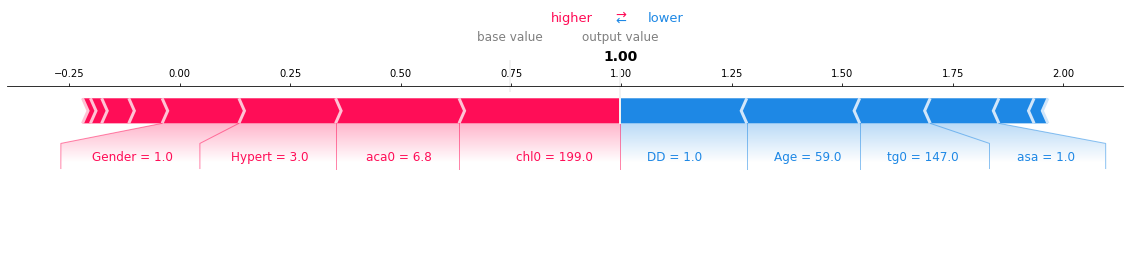

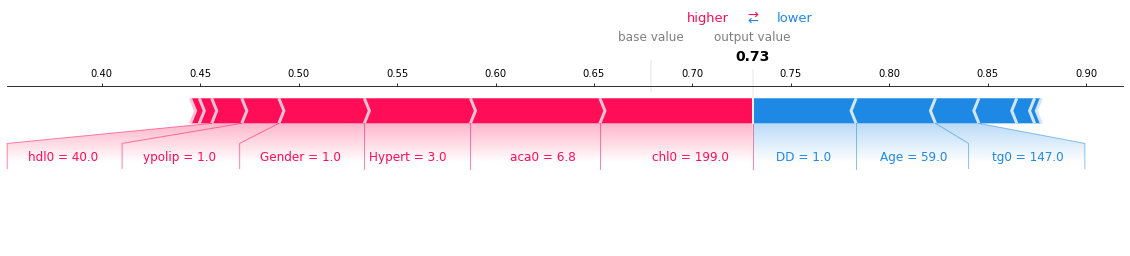

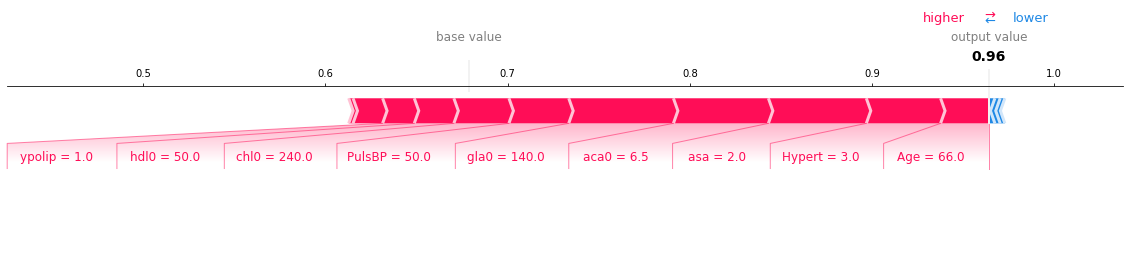

model 2  : 29
auc_valid 0.7934782608695652 0.972826 30
103
model 3  : 27
auc_valid 0.7391304347826086 0.907609 28
103
model 4  : 43
auc_valid 0.7717391304347826 0.961957 44
103
model 5  : 55
auc_valid 0.7934782608695652 0.940217 56


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


103
auc_valid: 0.7762681159420289
explainer.expected_value 0.1959419
explainer.expected_value 0.7478719
explainer.expected_value 0.766525
explainer.expected_value 0.6778839
explainer.expected_value 0.7033389
explainer.expected_value 0.8763113


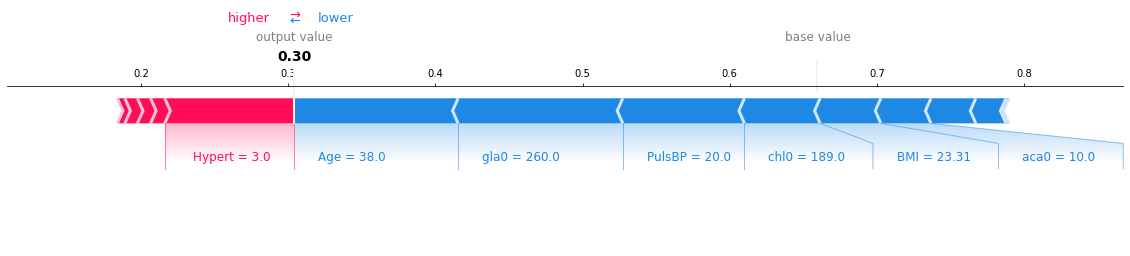

0.7692307692307692
---------------- 1 - fold -----------------------
                  Estimators
model 0  : 32
auc_valid 0.6195652173913043 0.581522 33
104
model 1  : 30
auc_valid 0.5489130434782609 0.576087 31
103
103
14
sssssssss    -1.6149867810308933
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.10183395 0.29659605 0.05097427 0.09513504 0.05971577 0.28357622
 0.06784767 0.5459065  0.02831829 0.11666985 0.05694579 0.05503042
 0.07072749 0.15657485 0.24373522 0.06245106 0.11627097 0.15094918
 0.4207971  0.08922761 0.3224501  0.19449817 0.39364356 0.04422747
 0.12091524 0.25555396 0.04049856 0.39896682 0.38213447 0.11713383
 0.01957852 0.62505525 0.15302005 0.26007846 0.26235303 0.20698453
 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


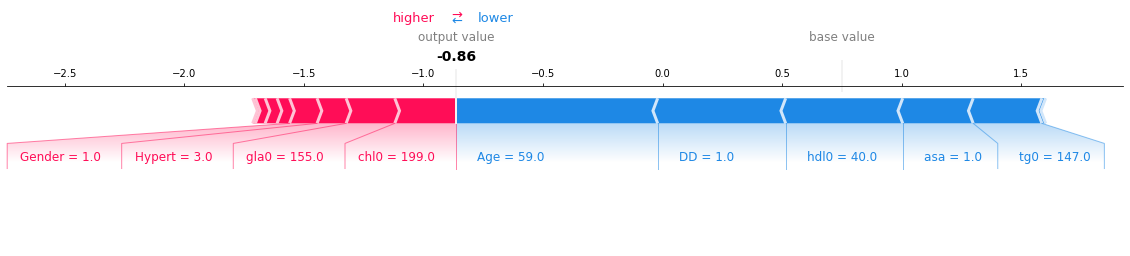

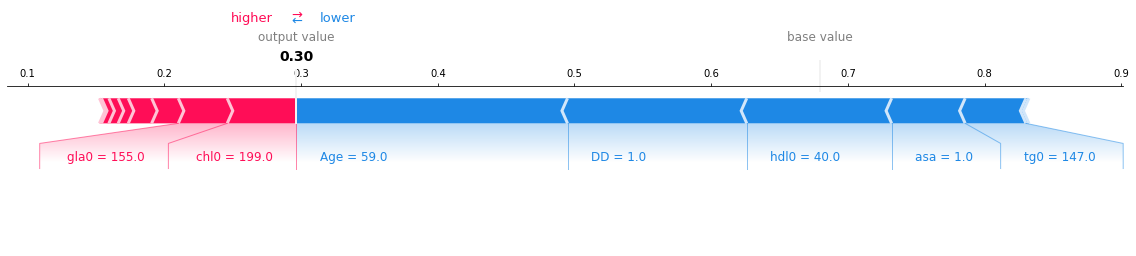

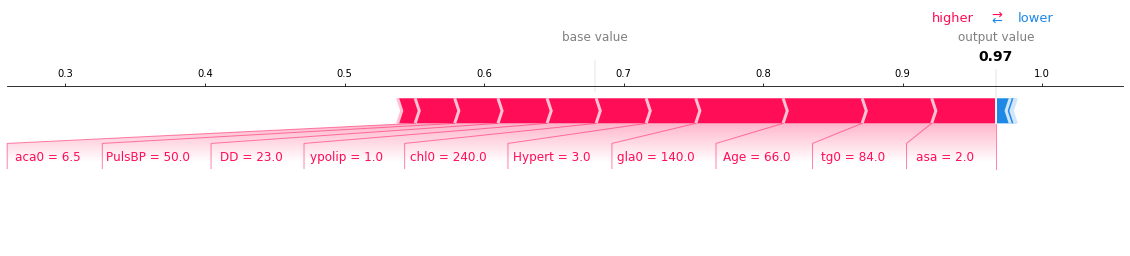

model 2  : 61
auc_valid 0.8695652173913043 0.983696 62
103
model 3  : 35
auc_valid 0.7717391304347826 0.913043 36
103
model 4  : 27
auc_valid 0.75 0.945652 28
103
model 5  : 31
auc_valid 0.7608695652173914 0.940217 32
103
auc_valid: 0.720108695652174
explainer.expected_value 0.69076157


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.75142616
explainer.expected_value 0.78426516
explainer.expected_value 0.7520537
explainer.expected_value 0.6457278
explainer.expected_value 0.7579874


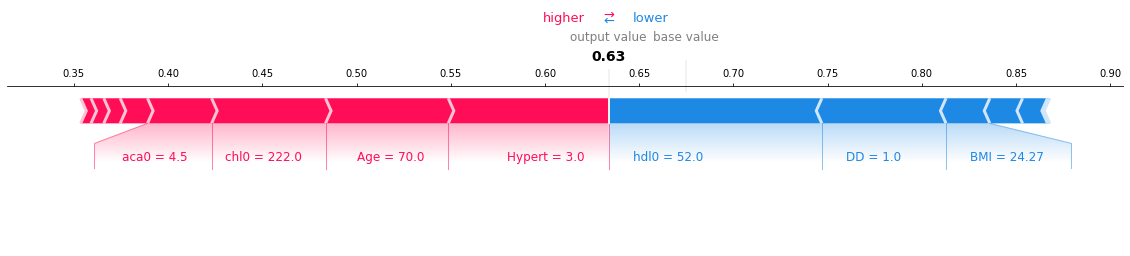

0.6923076923076923
---------------- 2 - fold -----------------------
                  Estimators
model 0  : 33
auc_valid 0.9021739130434783 0.956522 34
104
model 1  : 19
auc_valid 0.6195652173913043 0.538043 20
103
103
14
sssssssss    -2.1923375762999058
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1.]
probaprob    [0.3688672  0.17406636 0.14153212 0.09017621 0.2570125  0.08832055
 0.27000654 0.03707055 0.2556502  0.5558367  0.10945769 0.17994727
 0.13527045 0.2500805  0.27759793 0.10582419 0.47359595 0.05929269
 0.38140085 0.3890042  0.21795666 0.39958113 0.24155389 0.35206616
 0.17918922 0.1084387  0.3409525  0.17623296 0.06058166 0.53510284
 0.1542234  0.12980461 0.15081584 0.22184077 0.52669275 0.3881177
 0

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


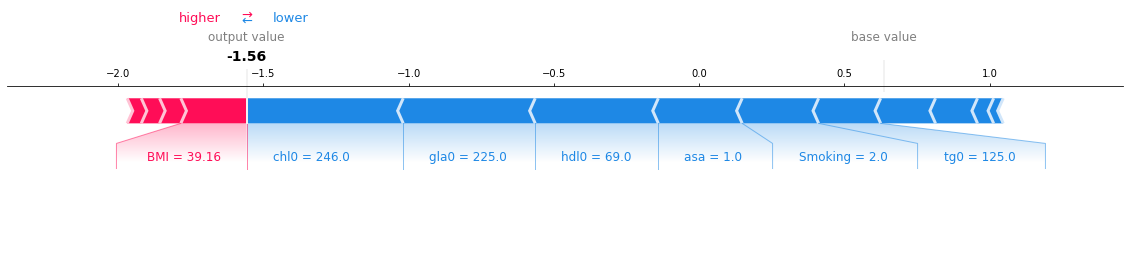

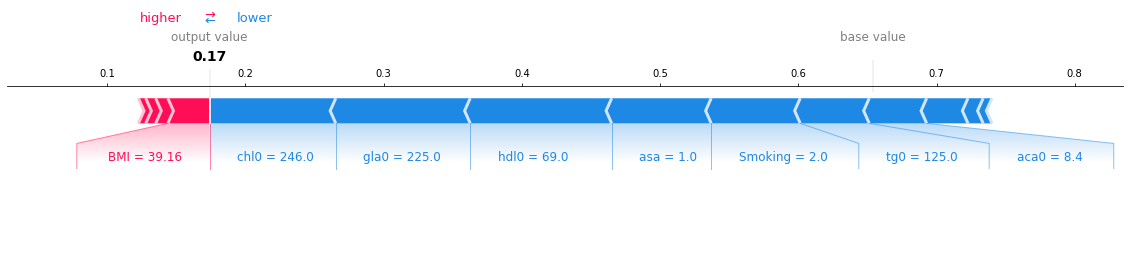

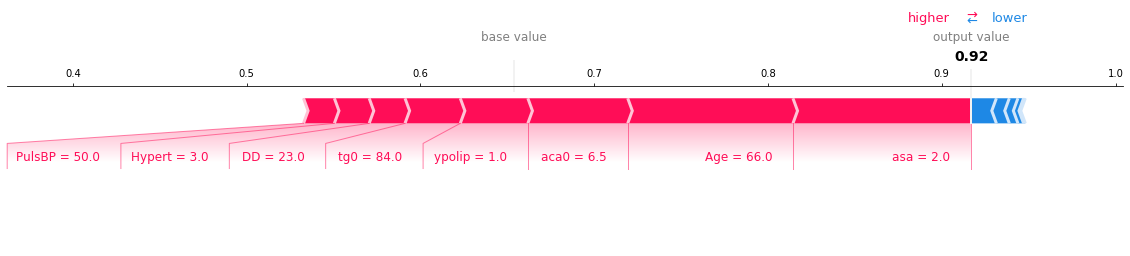

model 2  : 17
auc_valid 0.47282608695652173 0.538043 18
103
model 3  : 21
auc_valid 0.7173913043478262 0.929348 22
103
model 4  : 107
auc_valid 0.782608695652174 0.956522 108
103
model 5  : 6
auc_valid 0.6956521739130435 0.972826 7
103
auc_valid: 0.6983695652173914
explainer.expected_value 0.7717458


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.6352599
explainer.expected_value 0.5282375
explainer.expected_value 0.6543088
explainer.expected_value 0.8898864
explainer.expected_value 0.47449476


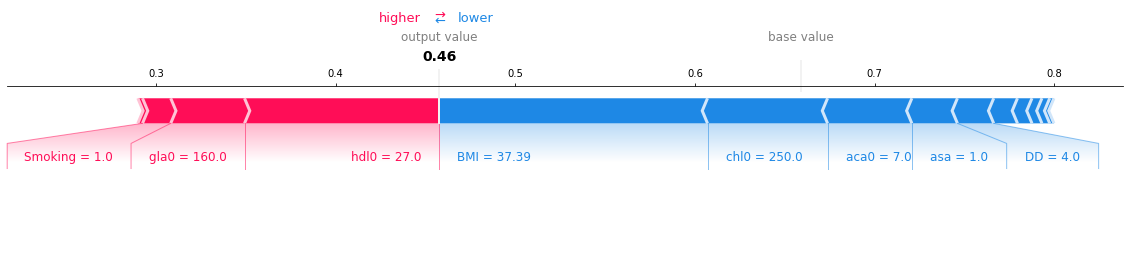

0.6442307692307693
---------------- 3 - fold -----------------------
                  Estimators
model 0  : 66
auc_valid 0.891304347826087 0.967391 67
104
model 1  : 10
auc_valid 0.9021739130434783 1.0 11
103
103
14
sssssssss    -3.0604234007187188
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1.]
probaprob    [0.25965104 0.06983853 0.19258243 0.08761555 0.46611798 0.21162046
 0.2341587  0.29951647 0.20056343 0.6269573  0.31539416 0.1859887
 0.45959884 0.40406883 0.38725618 0.24612987 0.5774419  0.5454874
 0.5224826  0.6672695  0.19411525 0.6230908  0.29679543 0.2678801
 0.295418   0.18726444 0.49372447 0.09256985 0.22861548 0.51164573
 0.44003025 0.18322635 0.2825624  0.5279315  0.34988856 0.12747616
 0.1928945

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


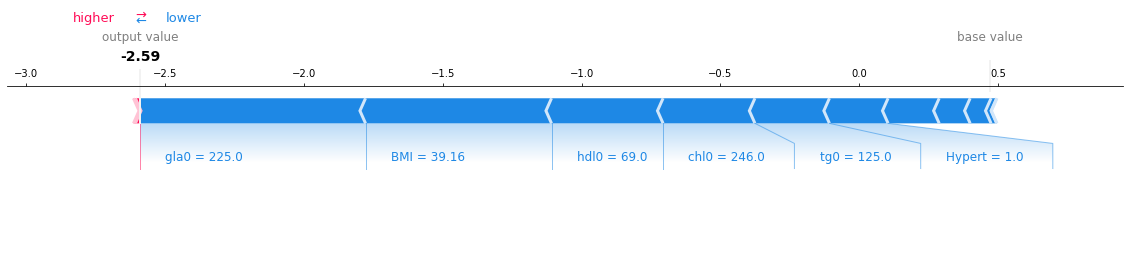

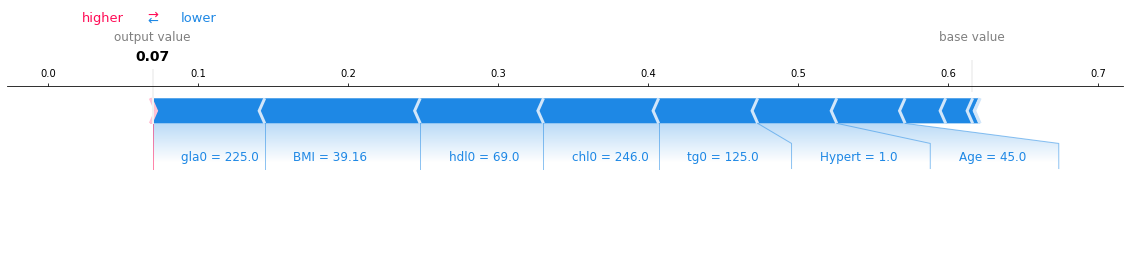

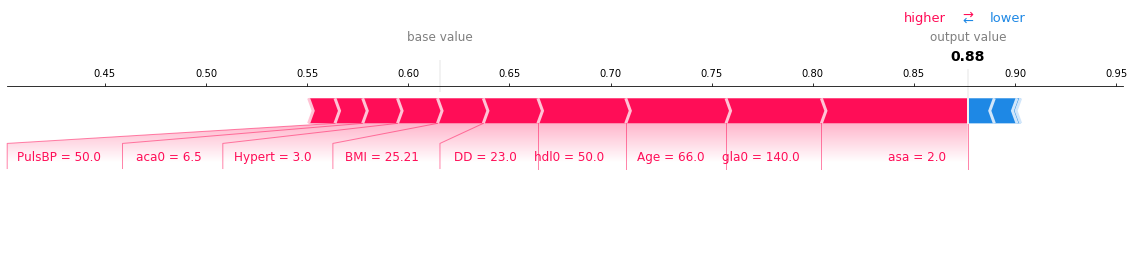

model 2  : 68
auc_valid 0.6793478260869565 0.728261 69
103
model 3  : 1
auc_valid 0.7173913043478262 0.728261 2
103
model 4  : 48
auc_valid 0.782608695652174 0.967391 49
103
model 5  : 8
auc_valid 0.7282608695652174 0.951087 9
103
auc_valid: 0.7835144927536233
explainer.expected_value 0.78701335
explainer.expected_value 0.471251


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.70627725
explainer.expected_value 0.17402135
explainer.expected_value 0.7163113
explainer.expected_value 0.5429562


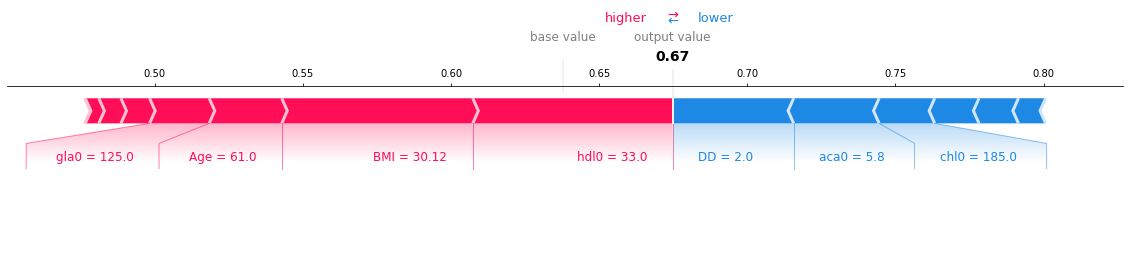

11111111111111
0.6826923076923078
---------------- 4 - fold -----------------------
                  Estimators
model 0  : 13
auc_valid 0.8586956521739131 0.967391 14
104
model 1  : 46
auc_valid 0.9782608695652174 1.0 47
103
103
14
sssssssss    -6.094226103276014
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.09020018 0.0049536  0.04039122 0.01292109 0.03580157 0.07269905
 0.0725286  0.0089151  0.10758678 0.47148624 0.085379   0.22151546
 0.2353996  0.37958154 0.32116994 0.08197774 0.17596869 0.34288862
 0.2750071  0.36083022 0.03819169 0.24077882 0.2312924  0.07668865
 0.16083303 0.02155993 0.3495692  0.01193649 0.06629695 0.40418714
 0.3457356  0.0082562  0.06345213 0.21998419 0.24019246 0.0

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


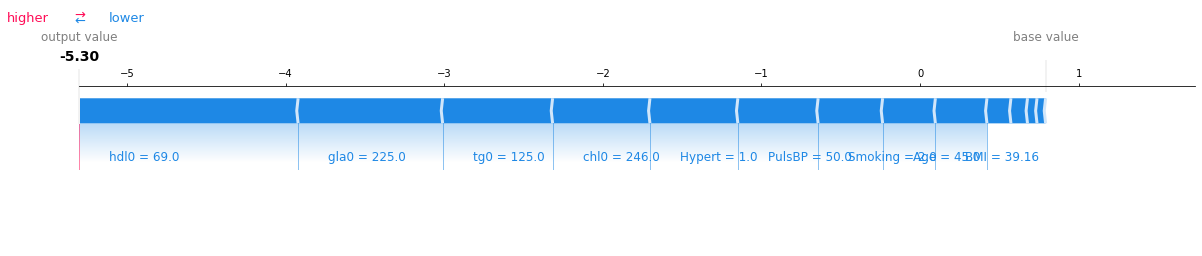

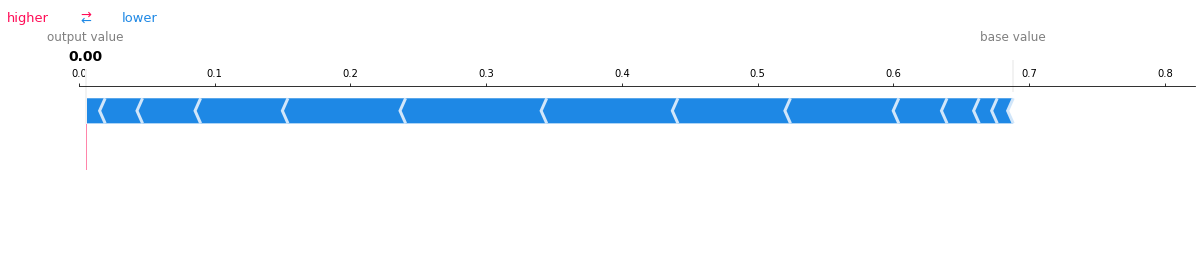

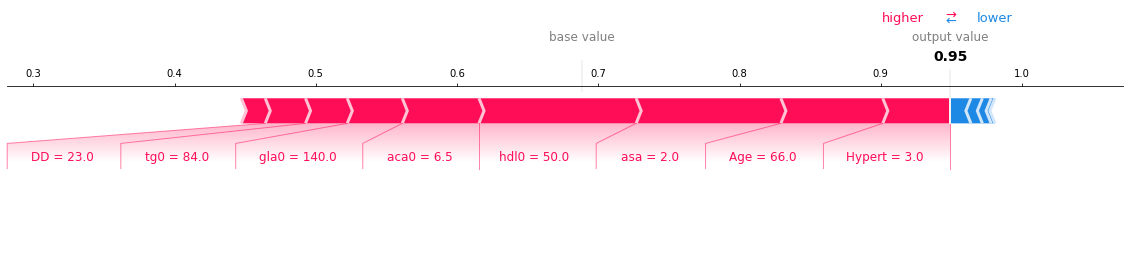

model 2  : 14
auc_valid 0.9021739130434783 1.0 15
103
model 3  : 32
auc_valid 0.625 0.684783 33
103
model 4  : 1
auc_valid 0.5923913043478262 0.51087 2
103
model 5  : 7
auc_valid 0.7934782608695652 0.934783 8
103
auc_valid: 0.7916666666666667
explainer.expected_value 0.61704373
explainer.expected_value 0.79155236
explainer.expected_value 0.49398652


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.60955507
explainer.expected_value 0.17623046
explainer.expected_value 0.4694139


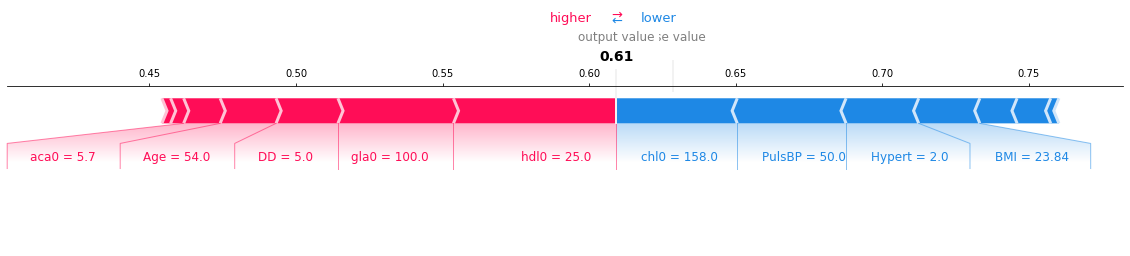

11111111111111
0.6153846153846154
---------------- 5 - fold -----------------------
                  Estimators
model 0  : 25
auc_valid 0.8586956521739131 0.961957 26
104
model 1  : 13
auc_valid 0.9673913043478262 1.0 14
103
103
14
sssssssss    -3.490604843944311
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.16816455 0.04599004 0.2439765  0.04020391 0.10662024 0.19194683
 0.36947027 0.20215337 0.38385615 0.3469068  0.22129336 0.31141257
 0.18743668 0.47961465 0.58958673 0.15354933 0.42145532 0.40457982
 0.4670957  0.35205457 0.05014675 0.53366107 0.40030426 0.2746775
 0.2185633  0.08721463 0.5916886  0.05652707 0.12327298 0.5358679
 0.5820454  0.08066627 0.23605247 0.36651668 0.19744194 0.044

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


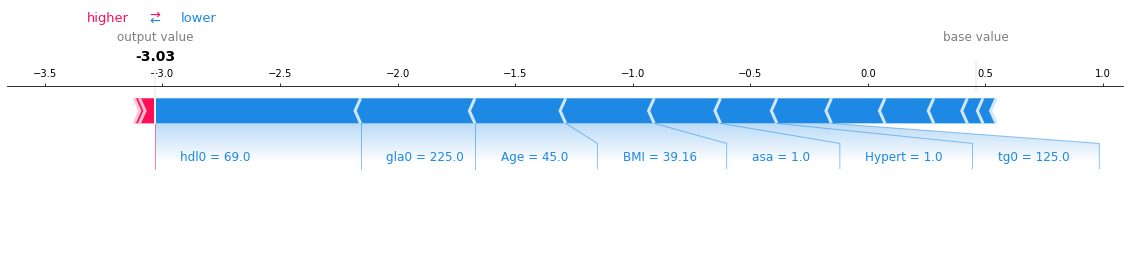

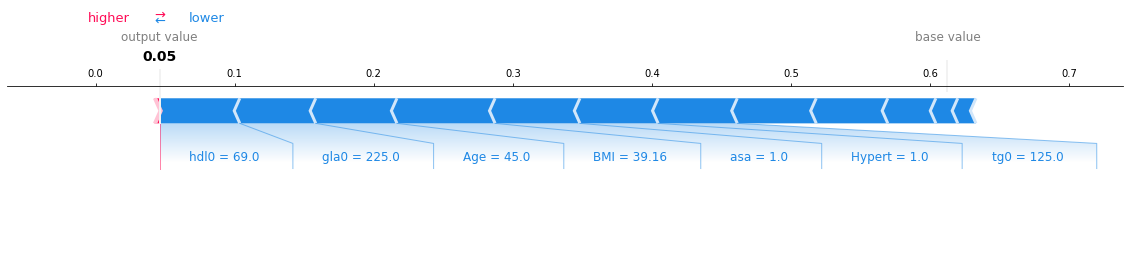

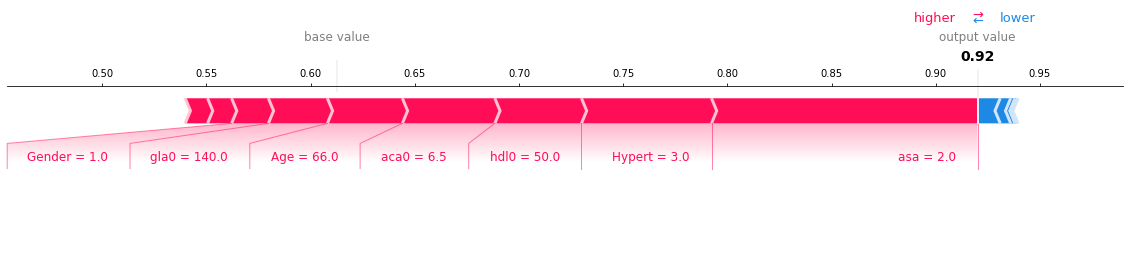

model 2  : 17
auc_valid 0.9456521739130435 1.0 18
103
model 3  : 18
auc_valid 0.9565217391304348 1.0 19
103
model 4  : 1
auc_valid 0.5923913043478262 0.730978 2
103
model 5  : 7
auc_valid 0.7717391304347826 0.826087 8
103
auc_valid: 0.8487318840579711
explainer.expected_value 0.68669724
explainer.expected_value 0.45835546
explainer.expected_value 0.49196482
explainer.expected_value 0.57350427


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.14632007
explainer.expected_value 0.43493426


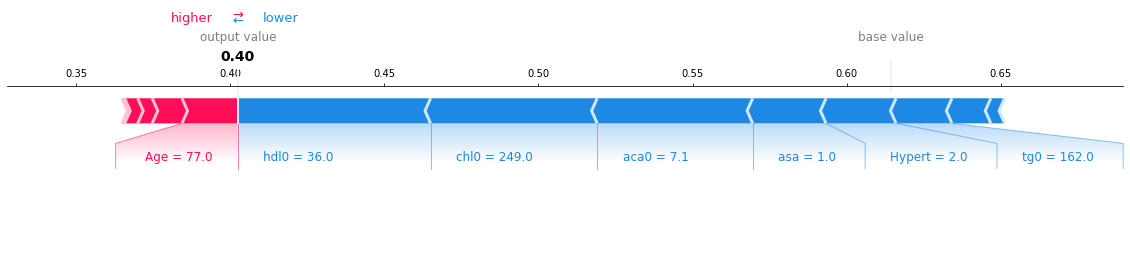

0.7019230769230769
---------------- 6 - fold -----------------------
                  Estimators
model 0  : 31
auc_valid 0.8369565217391304 0.940217 32
104
model 1  : 21
auc_valid 0.9782608695652174 1.0 22
103
103
14
sssssssss    -4.4707675483077765
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.07884107 0.01995844 0.05317776 0.02662259 0.13964017 0.08336426
 0.171882   0.09425253 0.20673236 0.58445764 0.27016026 0.31814072
 0.2586551  0.34952027 0.44125825 0.18836783 0.30502412 0.33458245
 0.27082375 0.6051827  0.13326916 0.3372832  0.13916604 0.16009954
 0.24327746 0.02569427 0.30473393 0.08187284 0.07889754 0.5364474
 0.40929592 0.09666725 0.22985901 0.48232222 0.31448302 0.03178336
 0.1181

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


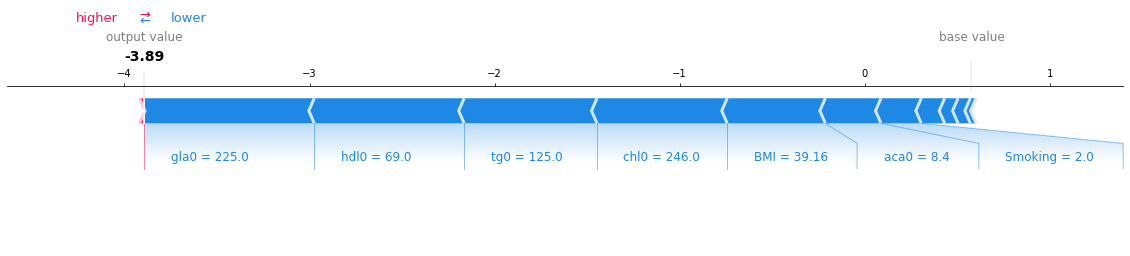

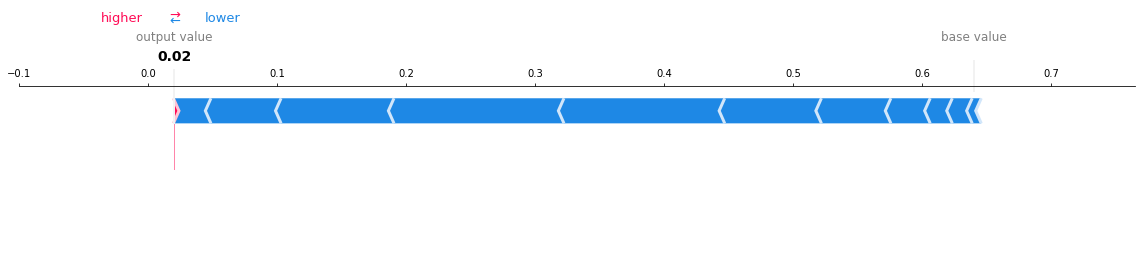

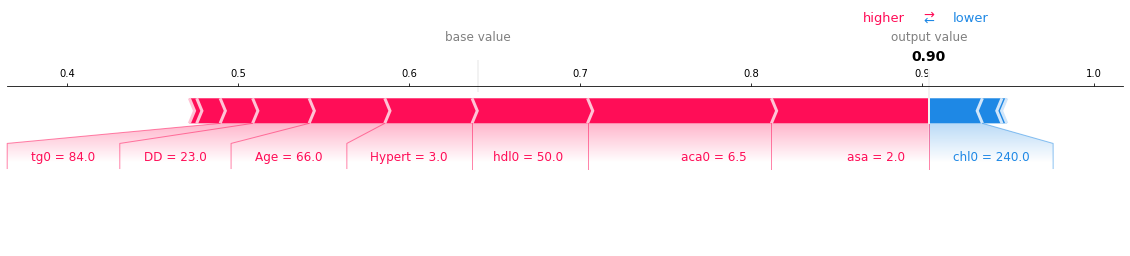

model 2  : 16
auc_valid 0.9347826086956521 1.0 17
103
model 3  : 21
auc_valid 0.9673913043478262 1.0 22
103
model 4  : 11
auc_valid 0.8152173913043479 0.978261 12
103
model 5  : 6
auc_valid 0.7717391304347826 0.673913 7
103
auc_valid: 0.8840579710144928
explainer.expected_value 0.7939352
explainer.expected_value 0.5768247
explainer.expected_value 0.47910488


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.64482737
explainer.expected_value 0.46213415
explainer.expected_value 0.3755555


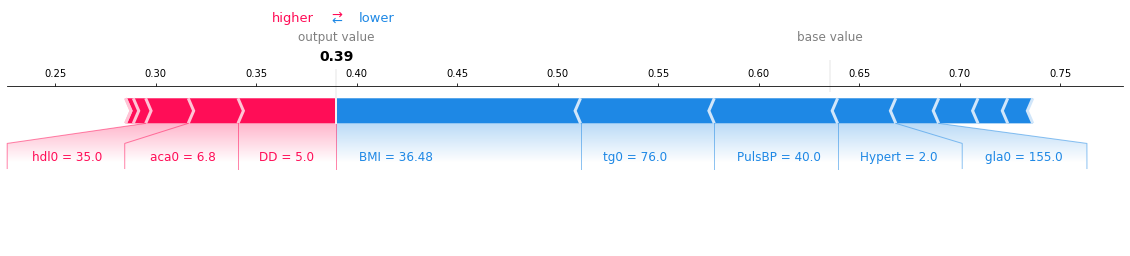

0.8653846153846154
---------------- 7 - fold -----------------------
                  Estimators
model 0  : 72
auc_valid 0.8804347826086957 0.961957 73
104
model 1  : 29
auc_valid 0.9456521739130435 1.0 30
103
103
14
sssssssss    -4.292607521638274
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.10249477 0.02569754 0.02843788 0.02710082 0.04442527 0.06669749
 0.06444614 0.09536646 0.34821516 0.5117458  0.30170566 0.19741346
 0.25002795 0.33253288 0.34257177 0.13176502 0.267221   0.28837046
 0.28489298 0.40551648 0.12699115 0.30712232 0.2727003  0.11116654
 0.25931787 0.02118322 0.08626793 0.04238639 0.18144825 0.5033492
 0.60963076 0.07893518 0.27700266 0.43196037 0.34781402 0.03231775
 0.04874

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


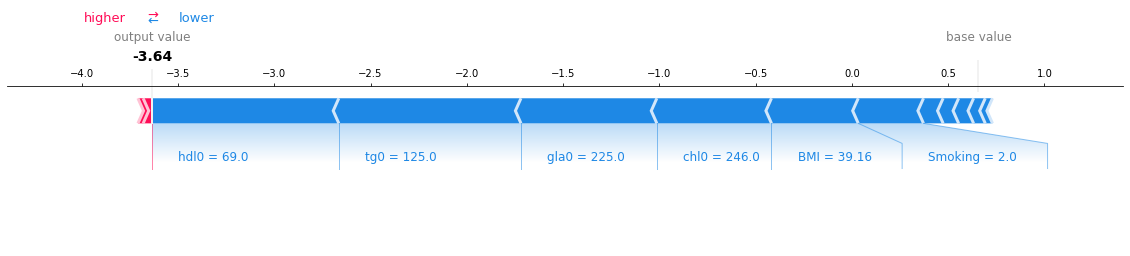

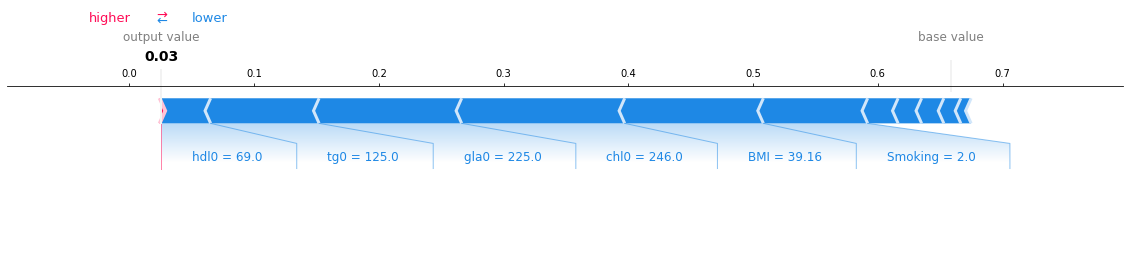

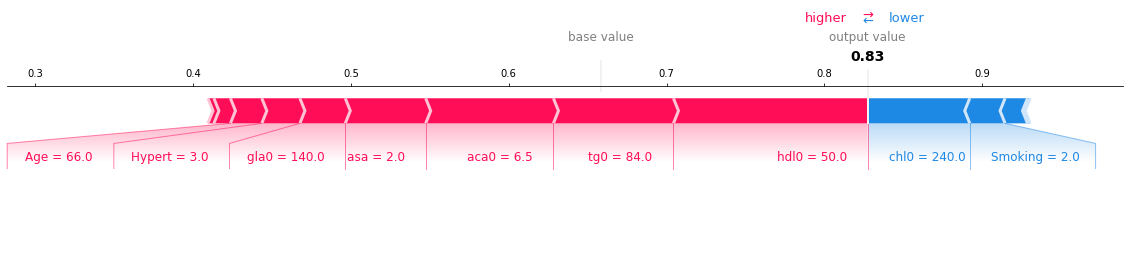

model 2  : 13
auc_valid 0.9347826086956521 1.0 14
103
model 3  : 42
auc_valid 0.9673913043478262 1.0 43
103
model 4  : 51
auc_valid 0.891304347826087 0.967391 52
103
model 5  : 5
auc_valid 0.782608695652174 0.978261 6


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


103
auc_valid: 0.9003623188405797
explainer.expected_value 0.8134507
explainer.expected_value 0.6572809
explainer.expected_value 0.47178885
explainer.expected_value 0.71550596
explainer.expected_value 0.71529
explainer.expected_value 0.34973478


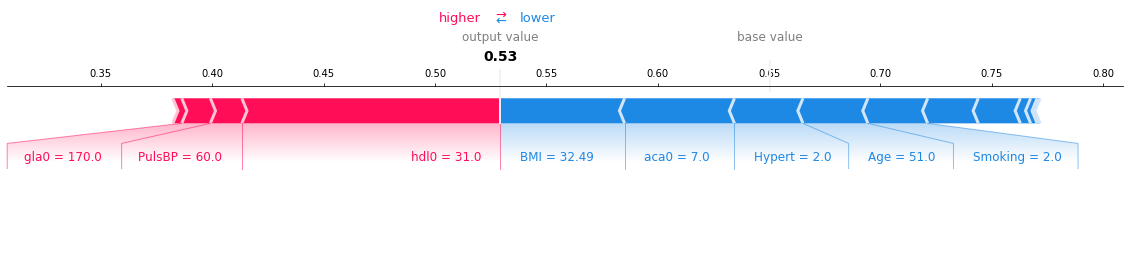

0.7596153846153846
---------------- 8 - fold -----------------------
                  Estimators
model 0  : 16
auc_valid 0.9347826086956521 0.967391 17
104
model 1  : 32
auc_valid 0.9565217391304348 1.0 33
103
103
14
sssssssss    -5.062645308673382
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.08449751 0.01116071 0.01346425 0.02083093 0.15025817 0.12428662
 0.09548759 0.02328614 0.2844234  0.6553737  0.10079615 0.1877788
 0.17628646 0.274572   0.35734084 0.12073345 0.2610556  0.45012844
 0.20598222 0.3912005  0.05663357 0.22326879 0.29632226 0.06684569
 0.11025611 0.01162805 0.20220998 0.06578673 0.19559416 0.4835752
 0.37005734 0.06463686 0.08545126 0.4204243  0.26521653 0.06481944
 0.073457

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


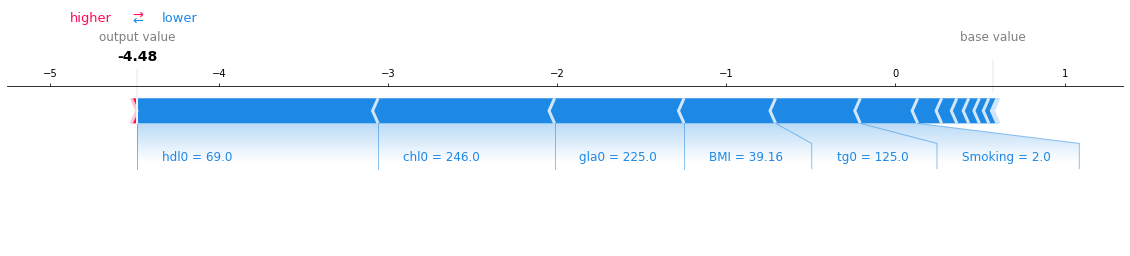

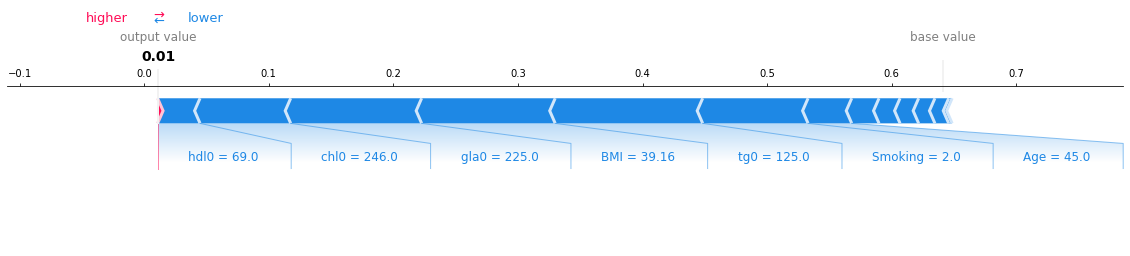

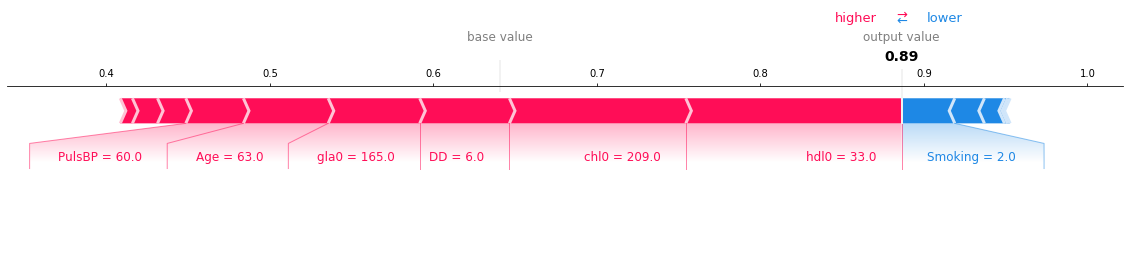

model 2  : 4
auc_valid 0.8369565217391304 1.0 5
103
model 3  : 69
auc_valid 0.9673913043478262 0.994565 70
103
model 4  : 59
auc_valid 0.8478260869565217 0.983696 60


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


103
model 5  : 56
auc_valid 0.7717391304347826 0.934783 57
103
auc_valid: 0.8858695652173914
explainer.expected_value 0.4470333
explainer.expected_value 0.57851386
explainer.expected_value 0.3525247
explainer.expected_value 0.76850057


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.8009913
explainer.expected_value 0.7127241


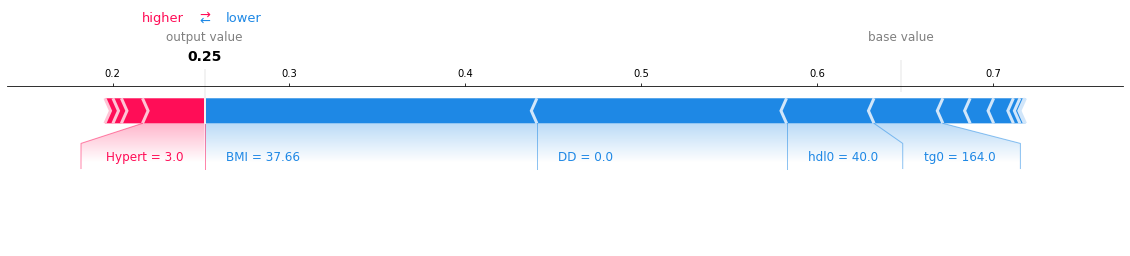

0.8846153846153846
---------------- 9 - fold -----------------------
                  Estimators
model 0  : 36
auc_valid 0.9891304347826088 1.0 37
103
model 1  : 21
auc_valid 0.9565217391304348 1.0 22
103
103
14
sssssssss    -4.262004899792373
ppppppppp    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
probaprob    [0.03390027 0.02438488 0.13755524 0.17085578 0.0861039  0.2424141
 0.12401432 0.09790597 0.04254625 0.06473421 0.5348958  0.14571531
 0.16704907 0.14326939 0.11866301 0.02450128 0.1404262  0.19566433
 0.08665454 0.255556   0.18202326 0.33994725 0.33000475 0.3608111
 0.09650113 0.15352741 0.08002078 0.04685793 0.11482847 0.01559825
 0.31323218 0.09617456 0.3614202  0.2018114  0.10906912 0.5752806
 0.20451565 0.3

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


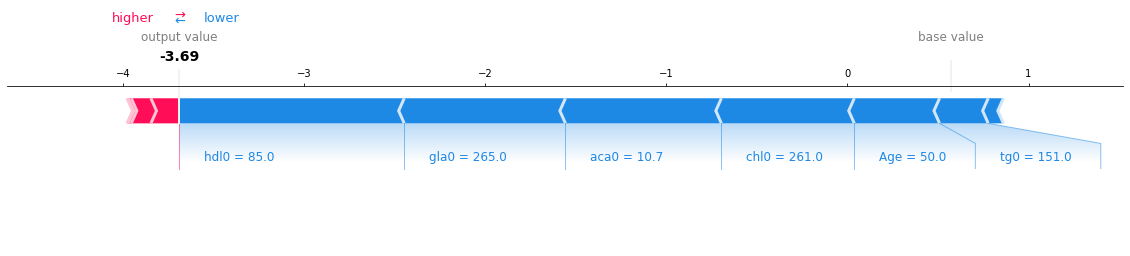

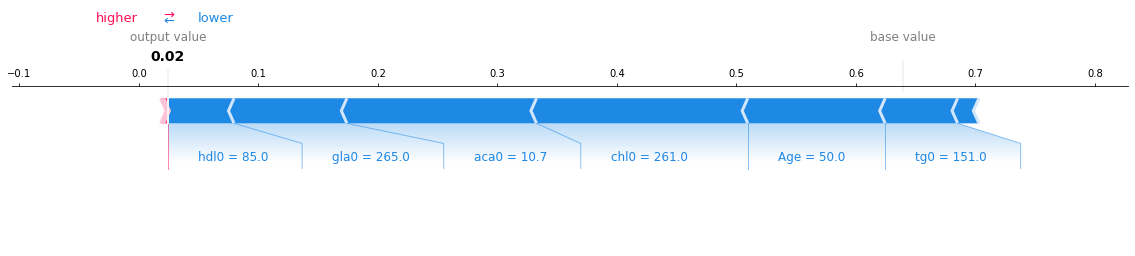

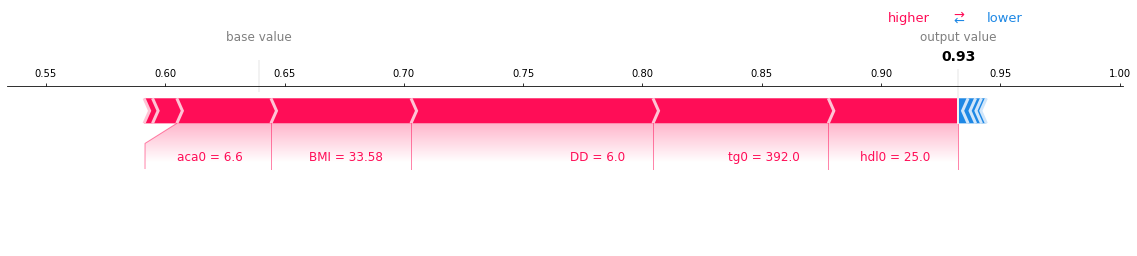

model 2  : 48
auc_valid 0.9021739130434783 0.98913 49
102
model 3  : 21
auc_valid 0.75 0.918478 22
102
model 4  : 48
auc_valid 0.8695652173913043 1.0 49
102
model 5  : 7
auc_valid 0.7934782608695652 0.896739 8
102
auc_valid: 0.8768115942028986
explainer.expected_value 0.6812913
explainer.expected_value 0.57290035


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


explainer.expected_value 0.7383884
explainer.expected_value 0.6186067
explainer.expected_value 0.7201233
explainer.expected_value 0.4610339


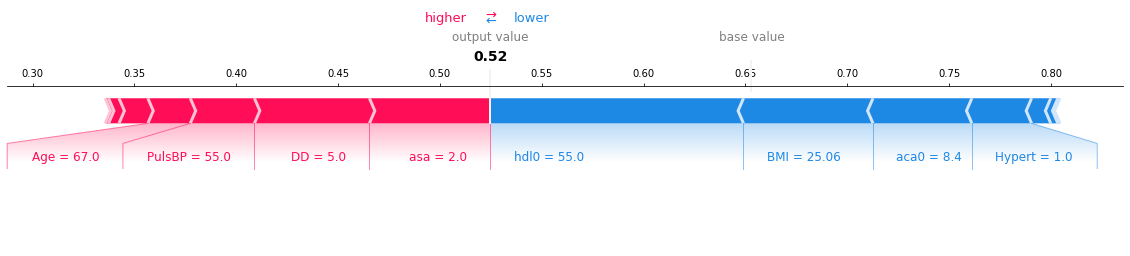

0.6117647058823529
[0.7692307692307692, 0.6923076923076923, 0.6442307692307693, 0.6826923076923078, 0.6153846153846154, 0.7019230769230769, 0.8653846153846154, 0.7596153846153846, 0.8846153846153846, 0.6117647058823529]
----------------------------------------------------------------
[0.3, 3, 200, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.7285714285714285
specificity  0.7304298642533936
sensitivity  0.715
auc          0.7227149321266968
----------------------------------------------------------------


In [32]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)


In [328]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=56
#50 = early stopping

1
0
---------------- 0 - fold -----------------------
                  Estimators
model 0  : 1
auc_valid 0.6358695652173914 0.625 2
model 1  : 23
auc_valid 0.9239130434782609 1.0 24
model 2  : 29
auc_valid 0.7934782608695652 0.972826 30
model 3  : 27
auc_valid 0.7391304347826086 0.907609 28
model 4  : 43
auc_valid 0.7717391304347826 0.961957 44
model 5  : 55
auc_valid 0.7934782608695652 0.940217 56
0.7692307692307692
---------------- 1 - fold -----------------------
                  Estimators
model 0  : 32
auc_valid 0.6195652173913043 0.581522 33
model 1  : 30
auc_valid 0.5489130434782609 0.576087 31
model 2  : 61
auc_valid 0.8695652173913043 0.983696 62
model 3  : 35
auc_valid 0.7717391304347826 0.913043 36
model 4  : 27
auc_valid 0.75 0.945652 28
model 5  : 31
auc_valid 0.7608695652173914 0.940217 32
0.6923076923076923
---------------- 2 - fold -----------------------
                  Estimators
model 0  : 33
auc_valid 0.9021739130434783 0.956522 34
model 1  : 19
auc_valid 0.6195